# Zero-Shot Inference with LLaVA-1.5-7B

This notebook demonstrates zero-shot inference capabilities of the LLaVA-1.5-7B model on custom images.

## 1. Load Model and Processor

Load the LLaVA-1.5-7B model from Hugging Face for zero-shot inference (following official HuggingFace example).

In [57]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

# Load the model in half-precision (following HuggingFace example)
print("Loading LLaVA-1.5-7B model...")
model = LlavaForConditionalGeneration.from_pretrained(
    "llava-hf/llava-1.5-7b-hf", 
    torch_dtype=torch.float16, 
    device_map="auto"
)
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
print("Model loaded successfully!")
print(f"Model device: {model.device}")

Loading LLaVA-1.5-7B model...


Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


Model loaded successfully!
Model device: cuda:0


## 2. Define Helper Functions

In [79]:
from PIL import Image
import requests
from io import BytesIO
import os

def load_image(image_path):
    """Load an image from local path or URL"""
    if image_path.startswith('http://') or image_path.startswith('https://'):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(image_path).convert('RGB')
    return image

def ask_question(image_path, question, model, processor):
    """
    Ask a question about an image using LLaVA model
    Following the official HuggingFace example format
    
    Args:
        image_path: path to image file or URL
        question: question to ask about the image
        model: LLaVA model
        processor: LLaVA processor
    
    Returns:
        answer: model's answer to the question
    """
    # Load image
    image = load_image(image_path)
    
    # Prepare conversation (following HuggingFace format)
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": question},
            ],
        },
    ]
    
    # Apply chat template
    prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
    
    # Process inputs (following HuggingFace example)
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device, torch.float16)
    
    # Generate answer
    generate_ids = model.generate(**inputs, max_new_tokens=100)
    
    # Decode answer
    output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    
    # Extract only the assistant's response
    answer = output.split("ASSISTANT:")[-1].strip()
    
    return answer

def display_qa_result(image_path, question, answer, question_num):
    """Display image with question and answer in two text boxes on the right side of the image."""
    import matplotlib.pyplot as plt
    import textwrap
    image = load_image(image_path)

    fig = plt.figure(figsize=(14, 8))
    # Show image on the left
    ax_img = plt.axes([0.05, 0.1, 0.55, 0.8])  # [left, bottom, width, height]
    ax_img.imshow(image)
    ax_img.axis('off')
    ax_img.set_title(f"Image: {os.path.basename(image_path)}", fontsize=16, fontweight='bold')

    # Prepare Q/A text
    q_text = f"Q{question_num}: {question}"
    a_text = f"A: {answer}"
    q_wrapped = textwrap.fill(q_text, width=36)
    a_wrapped = textwrap.fill(a_text, width=36)

    # Question box (top right)
    ax_q = plt.axes([0.62, 0.65, 0.3, 0.15])
    ax_q.axis('off')
    ax_q.text(0.02, 0.98, q_wrapped, fontsize=14, color='#0d47a1', fontweight='bold',
              va='top', ha='left', wrap=True,
              bbox=dict(facecolor='#e3f2fd', edgecolor='#1976d2', boxstyle='round,pad=0.5'))

    # Answer box (bottom right)
    ax_a = plt.axes([0.62, 0.35, 0.3, 0.26])
    ax_a.axis('off')
    ax_a.text(0.02, 0.98, a_wrapped, fontsize=14, color='#1b5e20', fontweight='bold',
              va='top', ha='left', wrap=True,
              bbox=dict(facecolor='#e8f5f0', edgecolor='#388e3c', boxstyle='round,pad=0.5'))

    plt.savefig(f'./outputs/zero_shot/qa_result_{question_num}.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Console Q&A
    print(f"\n{'='*80}")
    print(f"Question {question_num}: {question}")
    print(f"{'-'*80}")
    print(f"Answer: {answer}")
    print(f"{'='*80}\n")

## 3. Zero-Shot Inference on Custom Images

We will test the model on 5 different images with 2 questions each, covering various abilities:
- **OCR**: Text and symbol recognition
- **Semantic Understanding**: Understanding context and meaning
- **Visual Detail Recognition**: Identifying colors, shapes, and details
- **Spatial Reasoning**: Understanding spatial relationships

In [80]:
# Define the path to zero-shot images
data_dir = "data/zero_shot"

# Define all 5 images and their questions
test_cases = [
    {
        "image": "Calla Lily.jpg",
        "questions": [
            "What type of flower is shown in this image?",
            "Describe the color and shape of the flower in detail."
        ],
        "abilities": ["Semantic Understanding", "Visual Detail Recognition"]
    },
    {
        "image": "gundam.jpg",
        "questions": [
            "What is the main subject of this image?",
            "This image is a famous scene from Mobile Suit Gundam: Iron-Blooded Orphans. Could you tell me the background story and the plot of this scene?"
        ],
        "abilities": ["Object Recognition", "Semantic Understanding"]
    },
    {
        "image": "happy new year.PNG",
        "questions": [
            "What text can you read in this image?",
            "What is the occasion or event shown in this image?"
        ],
        "abilities": ["OCR (Text Recognition)", "Semantic Understanding"]
    },
    {
        "image": "math_meme.png",
        "questions": [
            "Can you explain the math formula in this image?",
            "What's absurd about this math formula?"
        ],
        "abilities": ["OCR (Math Symbols)", "Semantic Understanding"]
    },
    {
        "image": "mountain.JPG",
        "questions": [
            "Describe the landscape shown in this image.",
            "What is the weather condition and time of day in this image?"
        ],
        "abilities": ["Scene Description", "Environmental Understanding"]
    }
]

print(f"Total test cases: {len(test_cases)}")
print(f"Total questions: {sum(len(tc['questions']) for tc in test_cases)}")

Total test cases: 5
Total questions: 10


### Image 1: Calla Lily

**Tested Abilities**: Semantic Understanding, Visual Detail Recognition

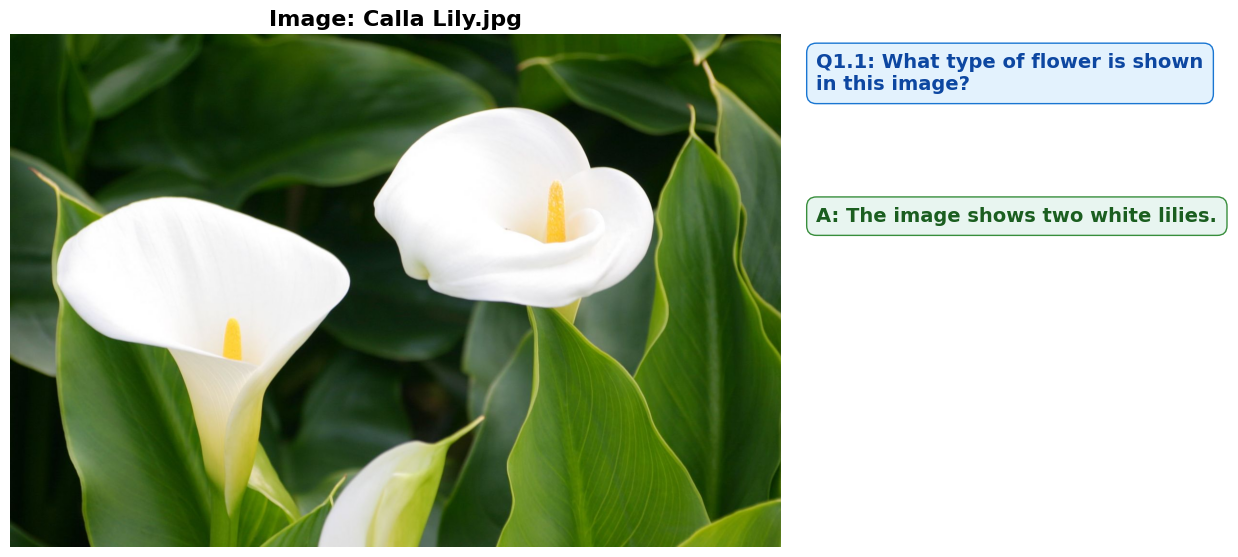


Question 1.1: What type of flower is shown in this image?
--------------------------------------------------------------------------------
Answer: The image shows two white lilies.



In [81]:
# Image 1: Calla Lily
image_path_1 = os.path.join(data_dir, test_cases[0]["image"])

# Question 1
question_1_1 = test_cases[0]["questions"][0]
answer_1_1 = ask_question(image_path_1, question_1_1, model, processor)
display_qa_result(image_path_1, question_1_1, answer_1_1, "1.1")

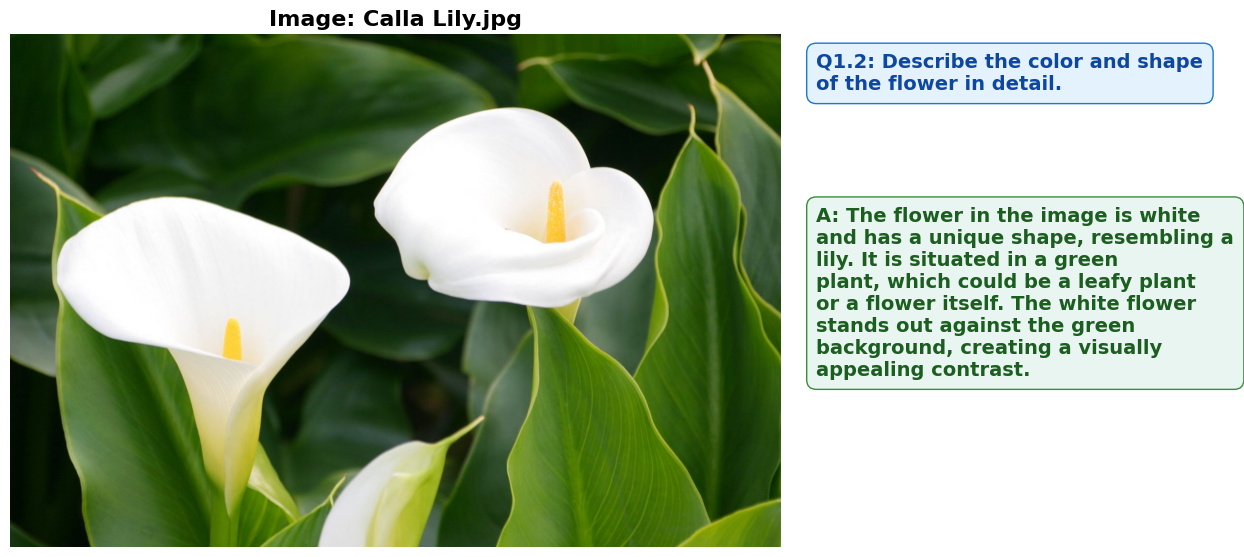


Question 1.2: Describe the color and shape of the flower in detail.
--------------------------------------------------------------------------------
Answer: The flower in the image is white and has a unique shape, resembling a lily. It is situated in a green plant, which could be a leafy plant or a flower itself. The white flower stands out against the green background, creating a visually appealing contrast.



In [82]:
# Question 2
question_1_2 = test_cases[0]["questions"][1]
answer_1_2 = ask_question(image_path_1, question_1_2, model, processor)
display_qa_result(image_path_1, question_1_2, answer_1_2, "1.2")

### Image 2: Gundam

**Tested Abilities**: Object Recognition, Color Recognition

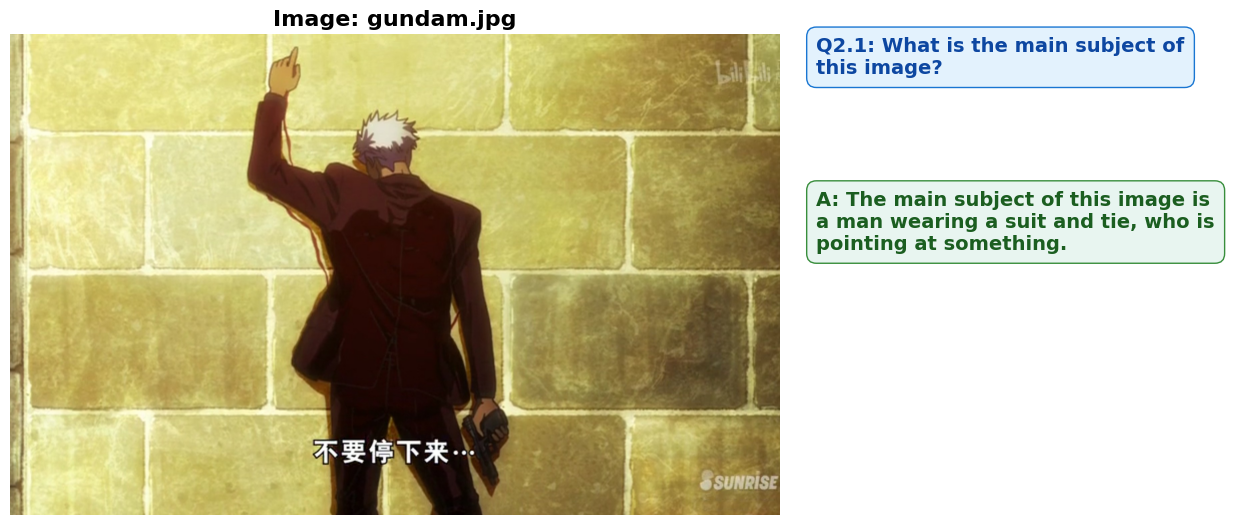


Question 2.1: What is the main subject of this image?
--------------------------------------------------------------------------------
Answer: The main subject of this image is a man wearing a suit and tie, who is pointing at something.



In [83]:
# Image 2: Gundam
image_path_2 = os.path.join(data_dir, test_cases[1]["image"])

# Question 1
question_2_1 = test_cases[1]["questions"][0]
answer_2_1 = ask_question(image_path_2, question_2_1, model, processor)
display_qa_result(image_path_2, question_2_1, answer_2_1, "2.1")

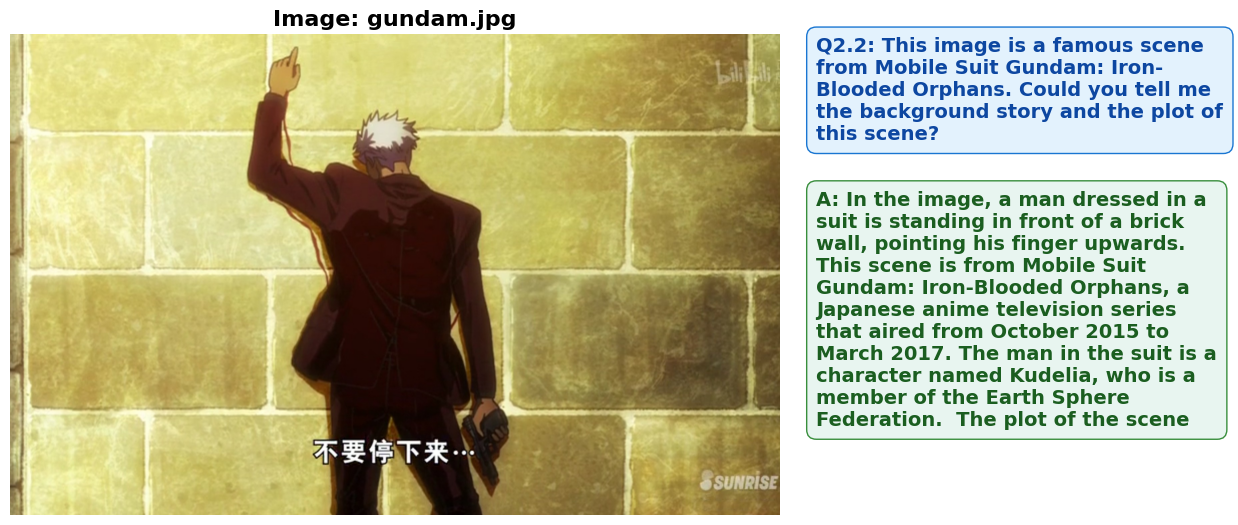


Question 2.2: This image is a famous scene from Mobile Suit Gundam: Iron-Blooded Orphans. Could you tell me the background story and the plot of this scene?
--------------------------------------------------------------------------------
Answer: In the image, a man dressed in a suit is standing in front of a brick wall, pointing his finger upwards. This scene is from Mobile Suit Gundam: Iron-Blooded Orphans, a Japanese anime television series that aired from October 2015 to March 2017. The man in the suit is a character named Kudelia, who is a member of the Earth Sphere Federation.

The plot of the scene



In [84]:
# Question 2
question_2_2 = test_cases[1]["questions"][1]
answer_2_2 = ask_question(image_path_2, question_2_2, model, processor)
display_qa_result(image_path_2, question_2_2, answer_2_2, "2.2")

### Image 3: Happy New Year

**Tested Abilities**: OCR (Text Recognition), Semantic Understanding

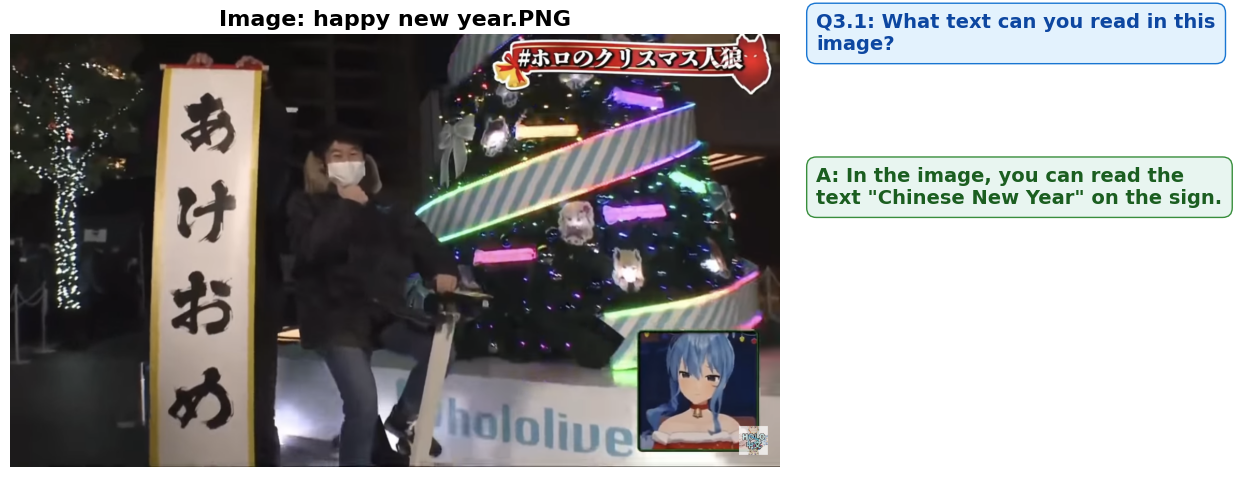


Question 3.1: What text can you read in this image?
--------------------------------------------------------------------------------
Answer: In the image, you can read the text "Chinese New Year" on the sign.



In [85]:
# Image 3: Happy New Year
image_path_3 = os.path.join(data_dir, test_cases[2]["image"])

# Question 1
question_3_1 = test_cases[2]["questions"][0]
answer_3_1 = ask_question(image_path_3, question_3_1, model, processor)
display_qa_result(image_path_3, question_3_1, answer_3_1, "3.1")

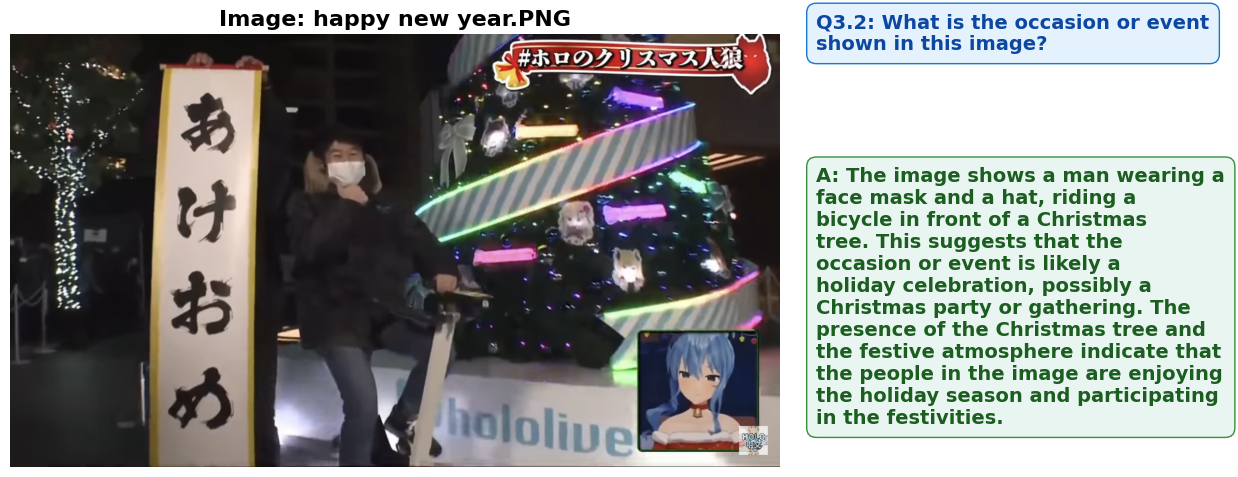


Question 3.2: What is the occasion or event shown in this image?
--------------------------------------------------------------------------------
Answer: The image shows a man wearing a face mask and a hat, riding a bicycle in front of a Christmas tree. This suggests that the occasion or event is likely a holiday celebration, possibly a Christmas party or gathering. The presence of the Christmas tree and the festive atmosphere indicate that the people in the image are enjoying the holiday season and participating in the festivities.



In [86]:
# Question 2
question_3_2 = test_cases[2]["questions"][1]
answer_3_2 = ask_question(image_path_3, question_3_2, model, processor)
display_qa_result(image_path_3, question_3_2, answer_3_2, "3.2")

### Image 4: Math Meme

**Tested Abilities**: OCR (Math Symbols), Context Understanding

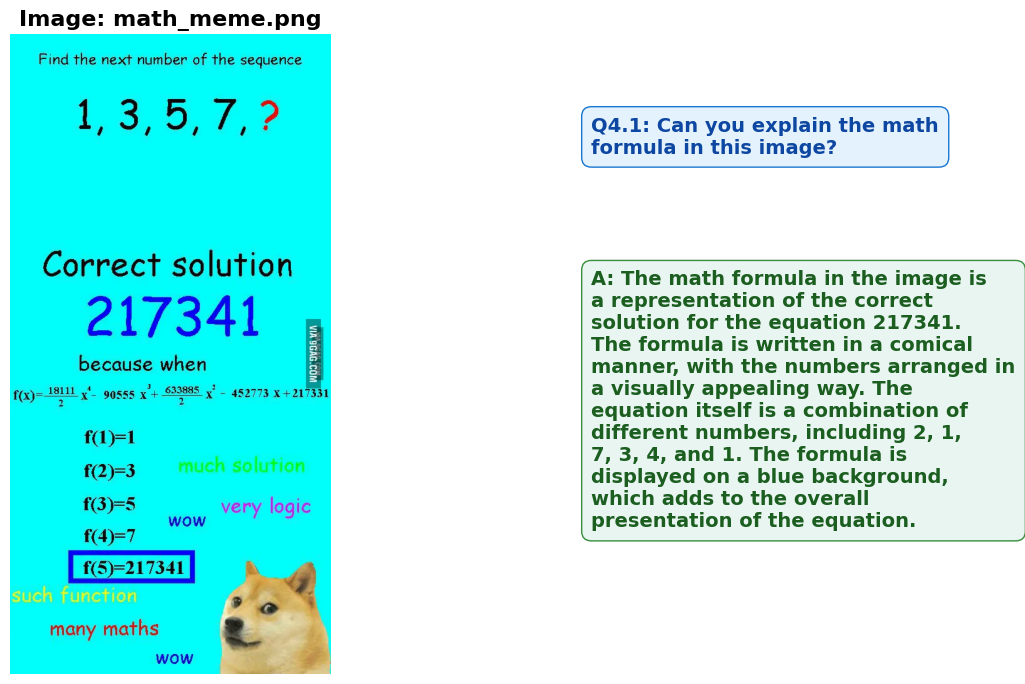


Question 4.1: Can you explain the math formula in this image?
--------------------------------------------------------------------------------
Answer: The math formula in the image is a representation of the correct solution for the equation 217341. The formula is written in a comical manner, with the numbers arranged in a visually appealing way. The equation itself is a combination of different numbers, including 2, 1, 7, 3, 4, and 1. The formula is displayed on a blue background, which adds to the overall presentation of the equation.



In [87]:
# Image 4: Math Meme
image_path_4 = os.path.join(data_dir, test_cases[3]["image"])

# Question 1
question_4_1 = test_cases[3]["questions"][0]
answer_4_1 = ask_question(image_path_4, question_4_1, model, processor)
display_qa_result(image_path_4, question_4_1, answer_4_1, "4.1")

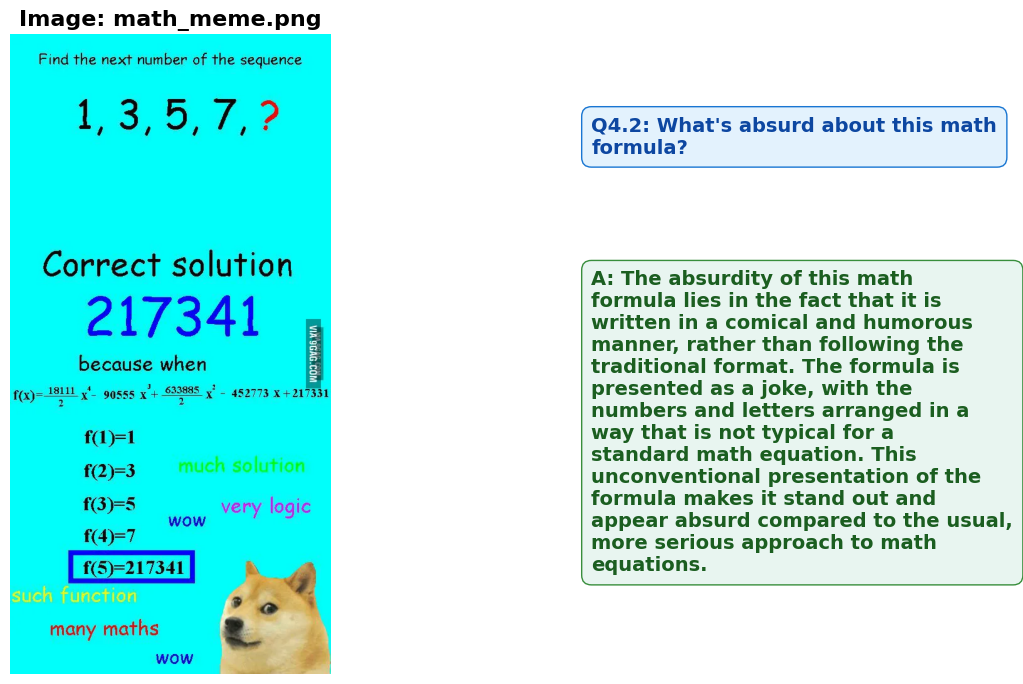


Question 4.2: What's absurd about this math formula?
--------------------------------------------------------------------------------
Answer: The absurdity of this math formula lies in the fact that it is written in a comical and humorous manner, rather than following the traditional format. The formula is presented as a joke, with the numbers and letters arranged in a way that is not typical for a standard math equation. This unconventional presentation of the formula makes it stand out and appear absurd compared to the usual, more serious approach to math equations.



In [88]:
# Question 2
question_4_2 = test_cases[3]["questions"][1]
answer_4_2 = ask_question(image_path_4, question_4_2, model, processor)
display_qa_result(image_path_4, question_4_2, answer_4_2, "4.2")

### Image 5: Mountain Landscape

**Tested Abilities**: Scene Description, Environmental Understanding

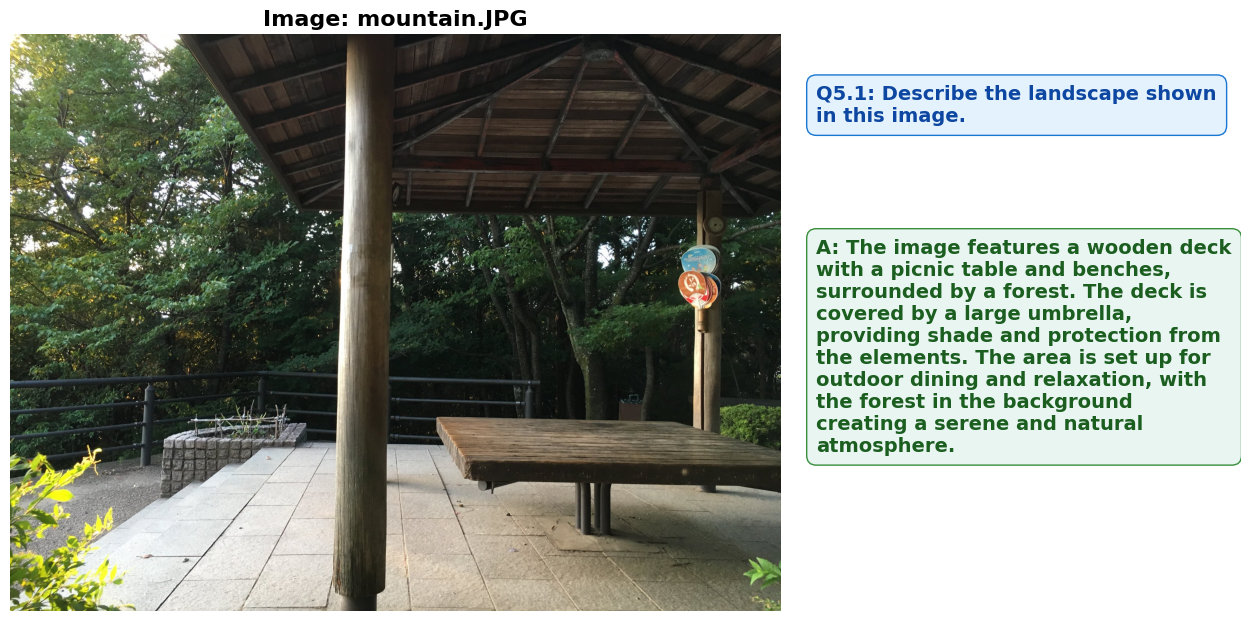


Question 5.1: Describe the landscape shown in this image.
--------------------------------------------------------------------------------
Answer: The image features a wooden deck with a picnic table and benches, surrounded by a forest. The deck is covered by a large umbrella, providing shade and protection from the elements. The area is set up for outdoor dining and relaxation, with the forest in the background creating a serene and natural atmosphere.



In [89]:
# Image 5: Mountain Landscape
image_path_5 = os.path.join(data_dir, test_cases[4]["image"])

# Question 1
question_5_1 = test_cases[4]["questions"][0]
answer_5_1 = ask_question(image_path_5, question_5_1, model, processor)
display_qa_result(image_path_5, question_5_1, answer_5_1, "5.1")

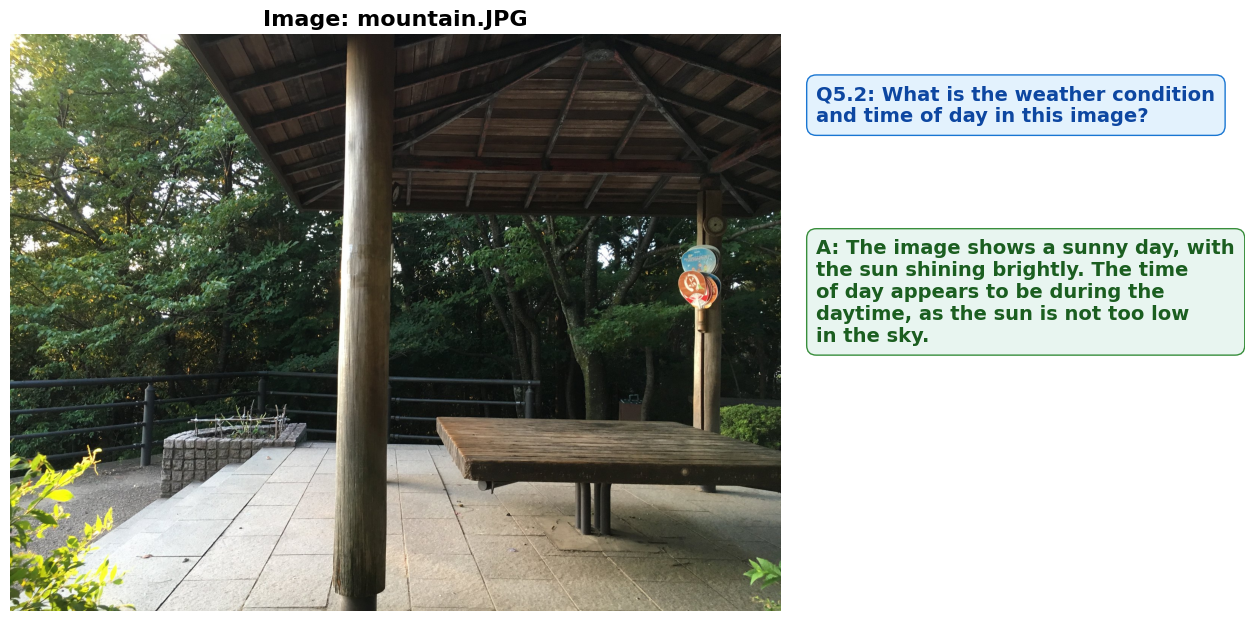


Question 5.2: What is the weather condition and time of day in this image?
--------------------------------------------------------------------------------
Answer: The image shows a sunny day, with the sun shining brightly. The time of day appears to be during the daytime, as the sun is not too low in the sky.



In [90]:
# Question 2
question_5_2 = test_cases[4]["questions"][1]
answer_5_2 = ask_question(image_path_5, question_5_2, model, processor)
display_qa_result(image_path_5, question_5_2, answer_5_2, "5.2")

## 6. Overall Discussion and Analysis

### Summary of Results

Create a summary table of all questions and answers:

In [91]:
import pandas as pd

# Collect all results
results = [
    {"Image": "Calla Lily", "Q#": "1.1", "Question": question_1_1, "Answer": answer_1_1},
    {"Image": "Calla Lily", "Q#": "1.2", "Question": question_1_2, "Answer": answer_1_2},
    {"Image": "Gundam", "Q#": "2.1", "Question": question_2_1, "Answer": answer_2_1},
    {"Image": "Gundam", "Q#": "2.2", "Question": question_2_2, "Answer": answer_2_2},
    {"Image": "Happy New Year", "Q#": "3.1", "Question": question_3_1, "Answer": answer_3_1},
    {"Image": "Happy New Year", "Q#": "3.2", "Question": question_3_2, "Answer": answer_3_2},
    {"Image": "Math Meme", "Q#": "4.1", "Question": question_4_1, "Answer": answer_4_1},
    {"Image": "Math Meme", "Q#": "4.2", "Question": question_4_2, "Answer": answer_4_2},
    {"Image": "Mountain", "Q#": "5.1", "Question": question_5_1, "Answer": answer_5_1},
    {"Image": "Mountain", "Q#": "5.2", "Question": question_5_2, "Answer": answer_5_2},
]

df_results = pd.DataFrame(results)
print("\nSummary Table of Zero-Shot Inference Results:")
print("="*100)
display(df_results)

# Save results to CSV
output_path = "outputs/zero_shot/zero_shot_results.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_results.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")


Summary Table of Zero-Shot Inference Results:


Image   Q#                                           Question  \
0      Calla Lily  1.1        What type of flower is shown in this image?   
1      Calla Lily  1.2  Describe the color and shape of the flower in ...   
2          Gundam  2.1            What is the main subject of this image?   
3          Gundam  2.2  This image is a famous scene from Mobile Suit ...   
4  Happy New Year  3.1              What text can you read in this image?   
5  Happy New Year  3.2  What is the occasion or event shown in this im...   
6       Math Meme  4.1    Can you explain the math formula in this image?   
7       Math Meme  4.2             What's absurd about this math formula?   
8        Mountain  5.1        Describe the landscape shown in this image.   
9        Mountain  5.2  What is the weather condition and time of day ...   

                                              Answer  
0                  The image shows two white lilies.  
1  The flower in the image is white and has a uni...  
2  The main subject of this image is a man wearin...  
3  In the image, a man dressed in a suit is stand...  
4  In the image, you can read the text "Chinese N...  
5  The image shows a man wearing a face mask and ...  
6  The math formula in the image is a representat...  
7  The absurdity of this math formula lies in the...  
8  The image features a wooden deck with a picnic...  
9  The image shows a sunny day, with the sun shin...


Results saved to: outputs/zero_shot/zero_shot_results.csv
